In [1]:
import pandas as pd
import numpy as np
from models import RegressionFNP
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.preprocessing import QuantileTransformer, PowerTransformer
import torch
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from scipy.signal import savgol_filter
import warnings
import math
import matplotlib.pyplot as plt
plt.style.use(['seaborn-whitegrid', 'seaborn-colorblind', 'seaborn-notebook'])
warnings.filterwarnings('ignore')

In [2]:
if torch.cuda.is_available()== True:  
  print('You are using a GPU type', torch.cuda.get_device_name())
else:
  print('You are using CPU')

You are using CPU


# The Functional Neural Process (FNP)

Based on the work from 
Amsterdam Machine Learning lab. <p><small>*Source: (https://github.com/AMLab-Amsterdam/FNP)*

A neural network (NN) is a parameterised function that can be tuned via gradient descent to approximate a labelled collection of data with high precision. A Gaussian process (GP), on the other hand, is a non-parametric probabilistic model that defines a distribution over possible functions, and is updated with new data via the rules of bayesian inference. GPs are probabilistic, data-efficient and flexible, however they are also computationally in-tensive and thus limited in their applicability. 


Neural Processes (NP) are a class of neural latent variable models that:
* defines distributions over functions, 
* capable of rapid adaptation to new observations, and 
* can estimate the uncertainty in their predictions (just as GP do).

###Differences betwen NP, ANP and FNP<p>

Functional Neural Processes (FNP) don't require explicit global latent variables in their construction as NP, but they rather operate by building a graph of dependencies among local latent variables, reminiscing more of autoencoder type of latent variable models. Neural Processes (NPs) define distributions over global latent variables in terms of subsets of the data, while Attentive Neural Processes (ANP) are extend NPs with a deterministic path that has across-attention mechanism among the datapoints. In a sense, FNPs can be seen as a variant where we discard the global latent variables and  instead incorporate cross-attention in the form of a dependency graph among local latent variables. 


###  Attention Mechanism<p>
An Attention Mechanism (AM) enables a neural network to focus only on relevant parts of input data instead of trying to deal with all data when doing a prediction task. AM learns in witch part of the dataset in a similar way than Neural Turing Machines (NTM), it is focusing everywhere, just to different extents.<p>
Neural Turing Machines combine a RNN with an external memory store in order to Neural Network  write and read from this memory everywhere, just to different extents at each step.
Instead of specifying a single location, the RNN outputs an 'attention distribution' that describes how we spread out the amount we care about different memory positions. With the same logic an 'attention distribution' describes how much we write at every location. We do this by having the new value of a position in memory be a convex combination of the old memory content and the write value, with the position between the two decided by the attention weight. To decide which positions in memory to focus their attention on, an NTM use a combination of two different methods:


1.   Content-based attention. Search through their memory and focus on places that match what they’re looking for.
2.   Location-based attention. Allows relative movement in memory, enabling the NTM to loop.




### Functional Neural Process Model

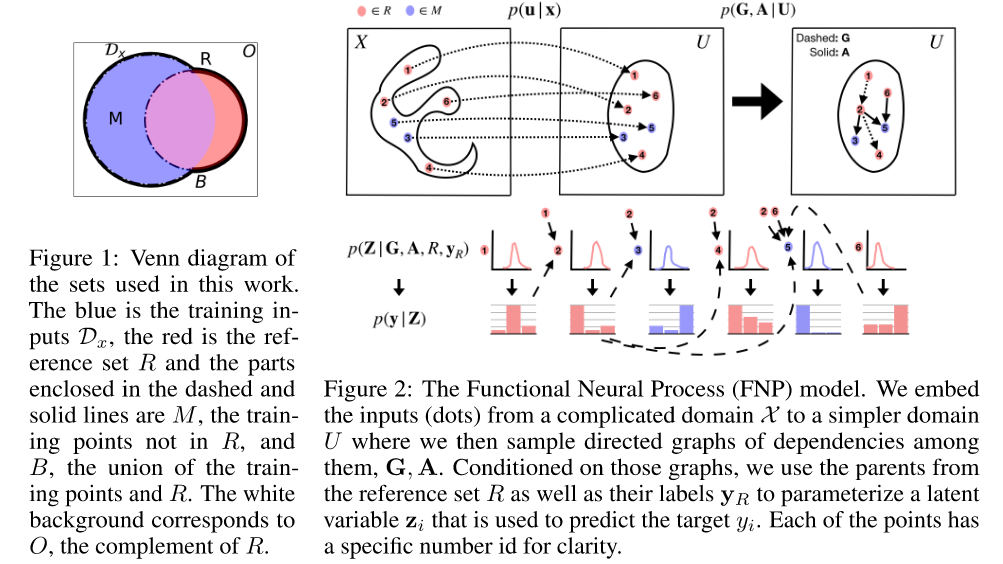

<small> Source:https://papers.nips.cc/paper/2019/file/db182d2552835bec774847e06406bfa2-Paper.pdf

FNP assumes a distribution over functions $h∈H$, from $x$ to $y$, by first selecting a 'reference' set of points from $X$,and then basing the probability distribution over $h$ around those points. Instead of following the process of NP (encode, aggregate and decode), in FNP there are two steps:


1.   Embedding the inputs $(x_i,y_i) ∈ D$ and $x_i ∈ X$ to a latent space $U$. We compute $p(x|u)$ 
2.   Constructing a graph of dependencies in the embedding space. We compute $p(G,A|U)$
3. Parametrizing the predictive distribution that we will use to to perform predictions for unseen points $x^*$. We compute $p(Z|A,G,R,y_R)$ and $p(y|Z)$.


### FNP and FNP+ models

In FNP, prediction for a given value of $y_i$depends on the input covariates $x_i$ only indirectly via the graphs $G,A$ which are a function of $u_i$. Intuitively, it encodes the inductive bias that predictions on points that are distant, i.e. have very small probability of being connected to the reference set via $A$, will default to an uninformative standard normal prior over $z_i$ hence a constant prediction for $y_i$. In the case of FNP+, we want to add extrapolation so we condition the prediction also on $u_i$, so we are adding a direct path to $U$ instead of working only with directed graphs of dependencies.

### References

* <small>'Neural Processes'. Garnelo, M., Schwarz, J., Rosenbaum, D., Viola, F., Rezende, D.J., Eslami, S.M. and Teh, Y.W. Neural processes. ICML Workshop on Theoretical Foundations and Applications of Deep Generative Models,arXiv:1807.01622, 2018,
(https://arxiv.org/pdf/1807.01622)
* 'The Functional Neural Process'.
Christos Louizos, Xiahan Shi, Klamer Schutte, Max Welling,  arXiv:1906.08324, 2019.
https://arxiv.org/abs/1906.08324
*  'Cross Attention Network for Few-shot Classification'. 
Ruibing Hou, Hong Chang, Bingpeng Ma, Shiguang Shan, Xilin Chen , 	arXiv:1910.07677, 2019 (https://arxiv.org/abs/1910.07677)
*  'Attention and Augmented Recurrent Neural Networks', Olah and Carter,  Distill, 2016. (http://distill.pub/2016/augmented-rnns)

# Regression example

In this part of the notebook we will illustrate how we can use the FNP model in a regression task. We will use a dataframe with real data describing the fitness industry in Spain. Data sources are Google trends for wird trends, Twitter for Sentiment Analysis and Yahoo finance for financial data. 

In [3]:
# define auxiliary functions that perform the visualization

def visualize(model, dx, stdx, stdy, cond_x=None, cond_y=None, all_x=None, all_y=None, samples=30, 
              range_y=(-100., 100.), title='', train=False):
    '''
    Visualizes the predictive distribution
    '''
    dxy = np.zeros((dx.shape[0], samples))
    if not train:
        model.eval()
    with torch.no_grad():
        dxi = torch.from_numpy(stdx.transform(dx).astype(np.float32))
        if torch.cuda.is_available():
            dxi = dxi.cuda()
        for j in range(samples):
            dxy[:, j] = model.predict(dxi, cond_x, cond_y).ravel()
    print()

    plt.figure(figsize=(20,7))
    mean_dxy, std_dxy = dxy.mean(axis=1), dxy.std(axis=1)
    # smooth it in order to avoid the sampling jitter
    mean_dxys = savgol_filter(mean_dxy, 31, 3)  #savgol(x= , window_length= , polyorder= )
    std_dxys = savgol_filter(std_dxy, 31, 3)
    
    if torch.cuda.is_available():
        all_x, all_y, cond_x, cond_y = all_x.cpu(), all_y.cpu(), cond_x.cpu(), cond_y.cpu()

    plt.plot(dx.ravel(), mean_dxys, label='Mean function')
    plt.plot(stdx.inverse_transform(all_x.data.numpy()).ravel(), stdy.inverse_transform(all_y.data.numpy()).ravel(), '.',
             label='Observations')
    if cond_x is not None:
        plt.plot(stdx.inverse_transform(cond_x.data.numpy()).ravel(), stdy.inverse_transform(cond_y.data.numpy()).ravel(), 'o',
             label='Reference')
    plt.fill_between(dx.ravel(), mean_dxys-1.*std_dxys, mean_dxys+1.*std_dxys, alpha=.1)
    plt.fill_between(dx.ravel(), mean_dxys-2.*std_dxys, mean_dxys+2.*std_dxys, alpha=.1)
    plt.fill_between(dx.ravel(), mean_dxys-3.*std_dxys, mean_dxys+3.*std_dxys, alpha=.1)

    plt.xlim([np.min(dx), np.max(dx)])
    plt.ylim(range_y)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=3, fancybox=False, shadow=False)
    plt.title(title)
    model.train()
    plt.show()

## Loading the data

We have to asume that our dataset features observes two necessary conditions: exchangeability and consistency. 
* According De Finetti's theorem, a sequence of random variables is said to be **exchangeable** if the joint probability distribution for the sequence does not change when the positions in the sequence in which finitely many of the random variables appear are altered. In our case, an exchangeable distribution over $D$ has to has a joint probability over these elements that is invariant to permutations of these points. To give in this condition we are ggoing to transform data in order to have a more Gaussian likely data. Since a Gaussian distribution is determined by its mean and covariance, this defines an exchangeable sequence. 
* **Consistency** refers to the phenomenon that probability defined on an observed sequence of points is the same as the probability defined on an extended sequence of points. To give in with this condition, we can play with transformations and use a transformation also making data more Gaussian like. 

In [4]:
#Load  data 
def load_csv(path):
    return pd.read_csv(path, 
                       engine='c', 
                       parse_dates=True, 
                       infer_datetime_format=True, 
                       low_memory=False)

In [5]:
path='gimnasio.csv'
df = load_csv(path)

In [6]:
def fix_missing(df):
    df = df.fillna(method='ffill')
    df = df.fillna(method='backfill')
    return df

In [7]:
df = fix_missing(df)
df = df.drop(columns=['date'])

In [8]:
#target variable y to make regression
target='Intensity_gimnasio'

In [9]:
X = np.linspace(0., len(df), len(df[target])).astype(np.float32)[:, np.newaxis]
lenX = len(X)
X = X.reshape(-1, 1)
y = df[target]  
y = fix_missing(y)
y = y.to_numpy()
y = y.reshape(-1, 1)
dx = np.linspace(X.min()-len(df)/3, X.max()+len(df)/3).astype(np.float32)[:, np.newaxis]

## Transforming the data

We can use different scalers for data transformation. How we scale data has a strong influence in results. We can use the following from SciKit Learn lib:
* **Standard Scaler** , as a general one, though gets influenced heavily by outliers. 
* **Robust Scaler** doesn't take the median into account, and only focuses on the parts where the bulk data is. So if outliers are present, Standard Scales gets affected as median is affected. Only in Normal distributions this influence is not importante and both scalers performs similarly. But when data does not follow a normal distribution, Robust Scaler outperforms Standard Scaler.
* **Power Transformer** applies a power transformation to each feature to make the data more Gaussian-like (zero mean and unit variance) in order to stabilize variance and minimize skewness. Yeo Johnson method is suitable for working with positive and negative values. 

In [10]:
#stdx, stdy = PowerTransformer(method='yeo-johnson').fit(X),PowerTransformer(method='yeo-johnson').fit(y)
#stdx, stdy = RobustScaler().fit(X),RobustScaler().fit(y)
stdx, stdy = QuantileTransformer(output_distribution='normal').fit(X),QuantileTransformer(output_distribution='normal').fit(y)
#stdx, stdy = StandardScaler().fit(X),StandardScaler().fit(y)
X, y = stdx.transform(X), stdy.transform(y)

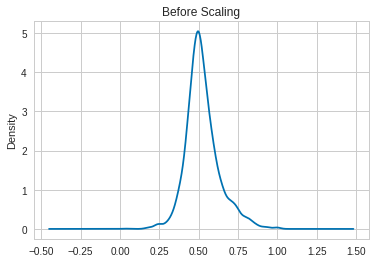

In [11]:
#original data
df[target].plot.kde(title='Before Scaling')

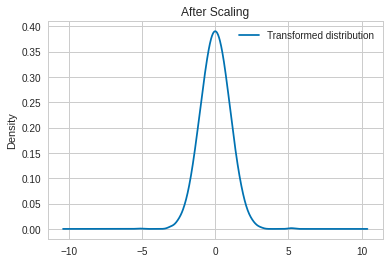

In [12]:
# transformed data (more Gaussian like)
pd.Series(y.reshape(-1)).plot.kde(title='After Scaling', label='Transformed distribution')
plt.legend()

To check if we satisfy the exchangeabilty condition in our points $y$ we can make an 'approximation' if we calculate Mutual Information (MI). If MI is zero,  we have independent variables and, for higher values, the more dependence there is between the variables.

In [13]:
from sklearn.feature_selection import mutual_info_regression

mi = mutual_info_regression(X.reshape(-1, 1), y)
print(f'Mutual Information ={mi[0]}')

Mutual Information =0.8711276134042105


## Model Implementation

* `dim_x`: Dimensionality of the input.
* `dim_y`: Dimensionality of the output.
* `dim_h`: Dimensionality of the hidden layers.
*`transf_y`: Transformation of the output (e.g. standardization).
*`n_layers`: Number of hidden layers.
*` use_plus`: Whether to use the FNP or FNP+.
* ` num_M`: How many points exist in the training set that are not part of the reference set ($M = D_x ∩ R$).
* `dim_z`: Dimensionality of the latents in the embedding space.
* `dim_u`: Dimensionality of the  latents that summarize the parents.
* `fb_z`: How many free bits do we allow for the latent variable $z$.





Epoch 0/1500, loss: 1.610
Epoch 300/1500, loss: 1.237
Epoch 600/1500, loss: 1.221
Epoch 900/1500, loss: 1.214
Epoch 1200/1500, loss: 1.205



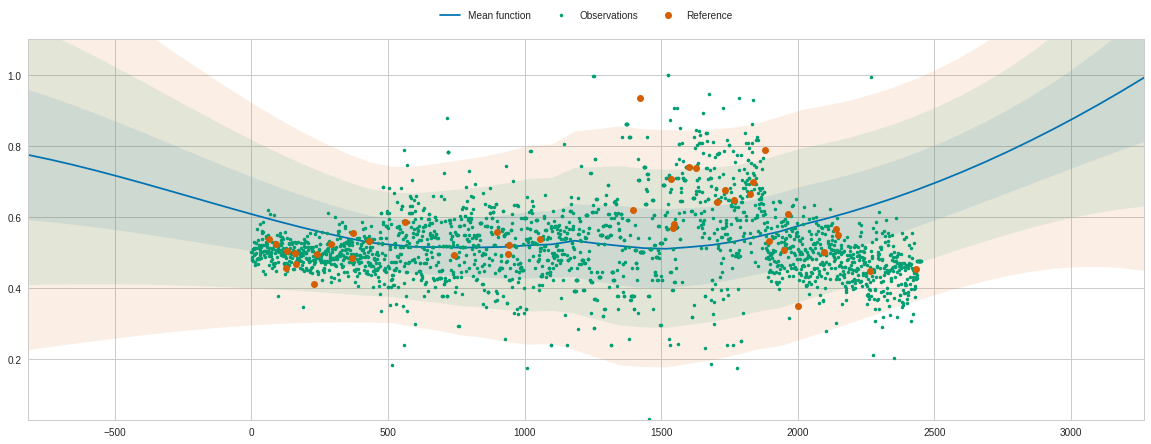

Train loss = 1.195
Done.


In [14]:
# r_R is the number of random reference points 
r_R = 40

idx = np.arange(X.shape[0])
#idxr is a random sample from idx of size r_R
idxR = np.random.choice(idx, size=(r_R,), replace=False) 
idxM = np.array([i for i in idx if i not in idxR.tolist()])

XR, yR = torch.from_numpy(X[idxR].astype(np.float32)), torch.from_numpy(y[idxR].astype(np.float32))
XM, yM = torch.from_numpy(X[idxM].astype(np.float32)), torch.from_numpy(y[idxM].astype(np.float32))
X, y = torch.from_numpy(X.astype(np.float32)), torch.from_numpy(y.astype(np.float32))
 
torch.manual_seed(5)
#Using FNP
#fnp = RegressionFNP(dim_x=1, 
#                    dim_y=1,
#                    dim_h=100, 
#                    transf_y=stdy, #standard deviation of y 
#                    n_layers=1, 
#                    use_plus=False                      
#                    num_M=XM.size(0), 
#                    dim_z=50,
#                    dim_u=3, 
#                    fb_z=1.0, 
#                   )

#Using FNP+
fnp = RegressionFNP(dim_x=1,
                    dim_y=1, 
                    dim_h=100, 
                    transf_y=stdy, #standard deviation of y 
                    n_layers=1,
                    use_plus=True,
                    num_M=XM.size(0),
                    dim_z=50, 
                    dim_u=3,
                    fb_z=3.0, 
                   )
# transfrom into CUDA tensors if CUDA is available
if torch.cuda.is_available():
    XR, XM, X = XR.cuda(), XM.cuda(), X.cuda()
    yR, yM, y = yR.cuda(), yM.cuda(), y.cuda()
    fnp = fnp.cuda()
    
optimizer = Adam(fnp.parameters(), lr=1e-3)
fnp.train()

y_n=y.cpu().data.numpy()
epochs = 1500
for i in range(epochs):
    optimizer.zero_grad()   
    loss = fnp(XR, yR, XM, yM)  
    loss.backward()
    optimizer.step()
        
    if i % int(epochs / 5) == 0:
        print('Epoch {}/{}, loss: {:.3f}'.format(i, epochs, loss.item()))
# Visualize how FNP learns the data in every epoch's step
#       visualize(fnp, dx, stdx, stdy, 
#               cond_x=XR, cond_y=yR, all_x=X, 
#               all_y=y, 
#               range_y=(df[target].min()*0.9, df[target].max()*1.1), #
#               samples=30) #before: 100
visualize(fnp, dx, stdx, stdy, cond_x=XR, 
          cond_y=yR, all_x=X, all_y=y, range_y=(df[target].min()*0.9, df[target].max()*1.1), # before: (-2.,3.)
          samples=50)
print('Train loss = {:.3f}'.format(loss.item()))
print('Done.')

## Prediction performance and uncertainty

We have to use regression metrics to compute the our model performance. We use computes Mean Square Error ($mse$), a risk metric corresponding to the expected value of the squared (quadratic) error or loss, and also r2_score function ($R^2$).

In [15]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# model optimization only
loss = RegressionFNP.forward(fnp ,XR, yR, XM, yM, kl_anneal=1.).cpu().detach().numpy()[0]
# evaluate model
pred= fnp.predict(X, XR, yR)
r2 = r2_score(y.cpu().numpy(), pred)
mse = mean_squared_error(y.cpu().numpy(), pred, squared=False)
print(f'Loss Function = {loss}')
print(f'Root Mean Squared Error = {mse}')
print(f'r2= {r2}')

Loss Function = 1.1978116035461426
Root Mean Squared Error = 1.1364225149154663
r2= -0.26328100675730615


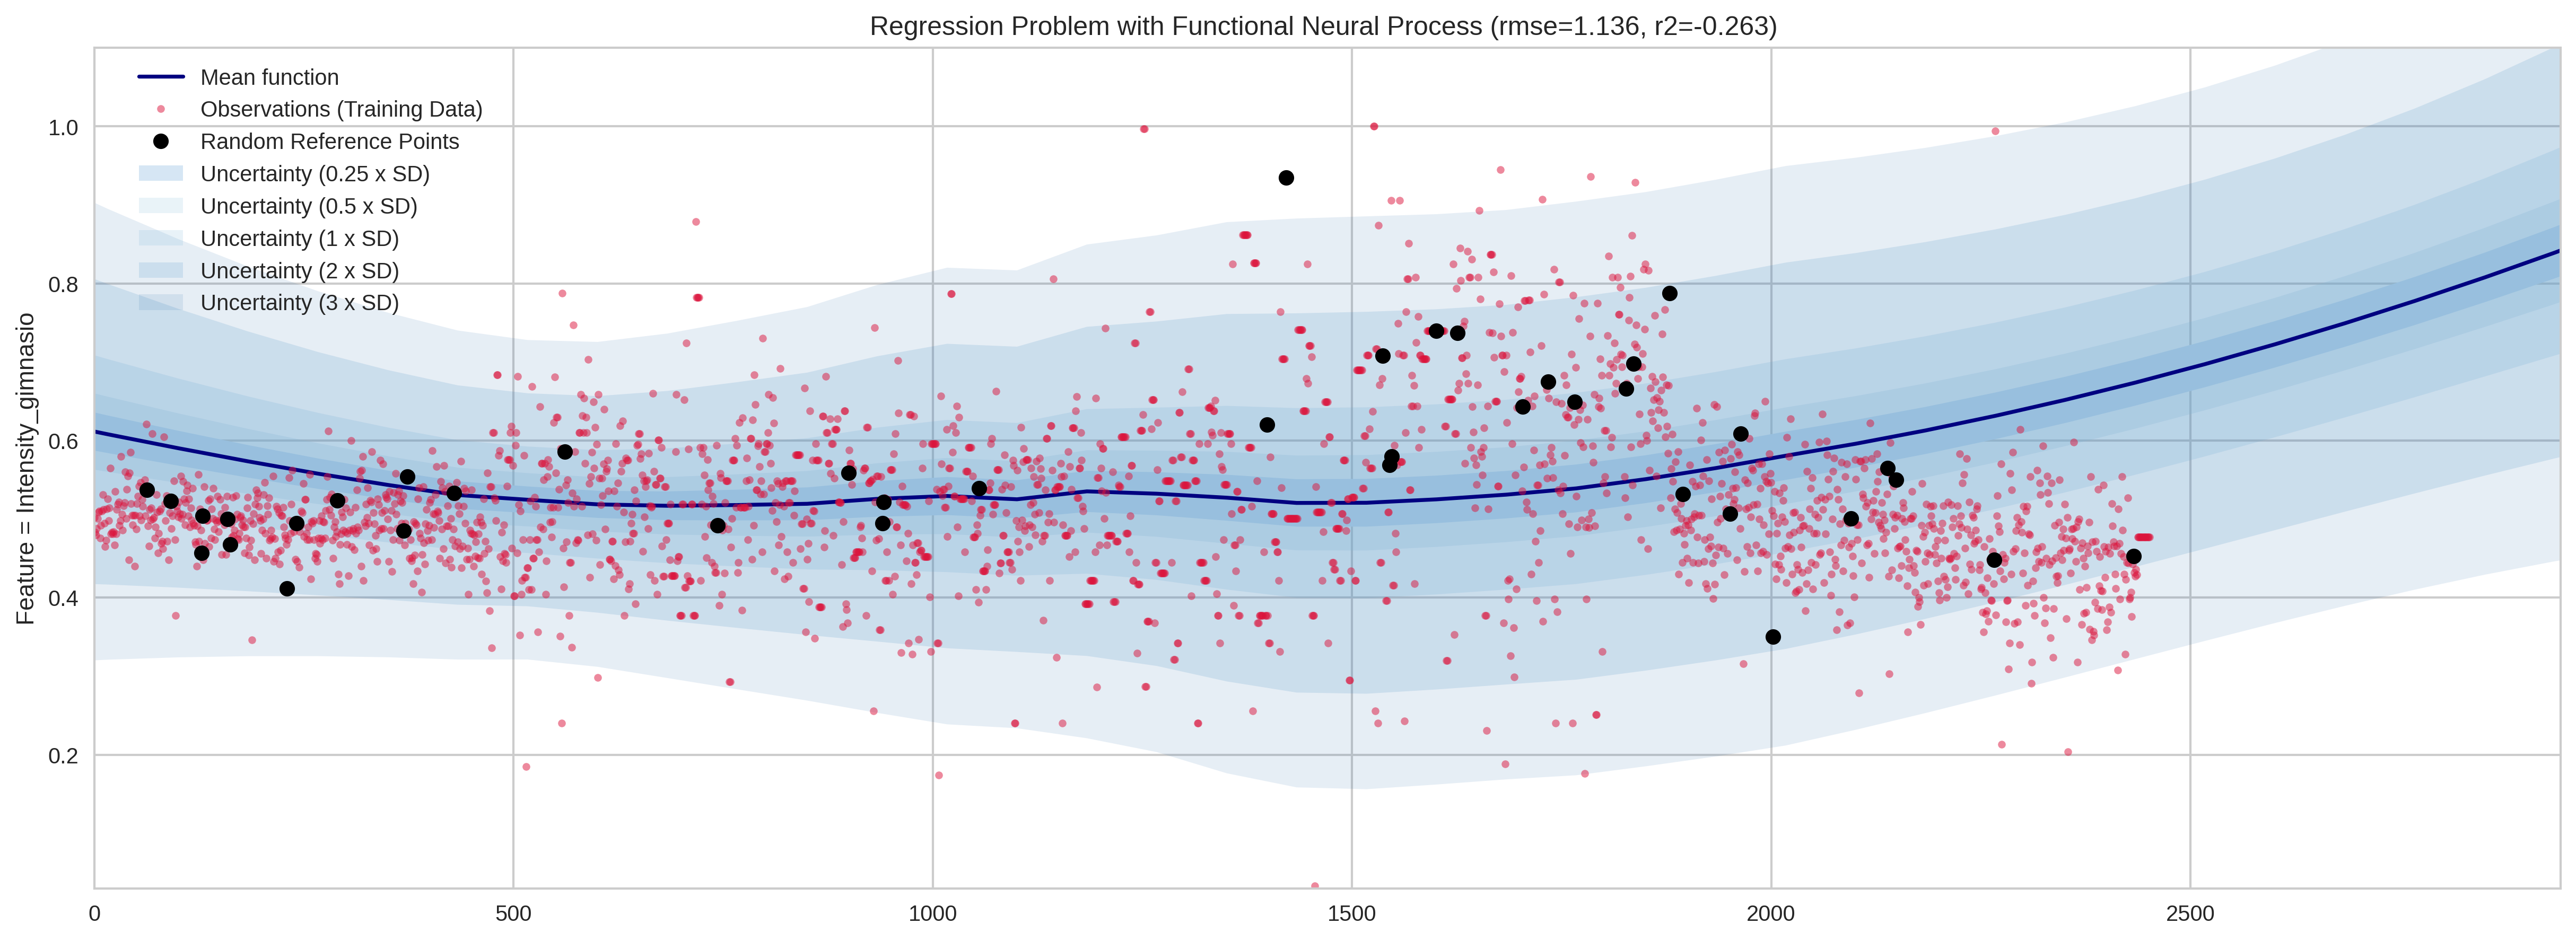

In [44]:
import seaborn as sns
plt.figure(figsize=(20,7), dpi=300)

samples=25
model=fnp
all_x=X
all_y=y
cond_x=XR
cond_y=yR
range_y=(df[target].min()*0.9, df[target].max()*1.1)
dxy = np.zeros((dx.shape[0], samples))

with torch.no_grad():
  dxi = torch.from_numpy(stdx.transform(dx).astype(np.float32))
  if torch.cuda.is_available():
    dxi = dxi.cuda()
  for j in range(samples):
    dxy[:, j] = model.predict(dxi, cond_x, cond_y).ravel()

mean_dxy, std_dxy = dxy.mean(axis=1), dxy.std(axis=1)
mean_dxys = savgol_filter(mean_dxy, 31, 3)  #savgol(x= , window_length= , polyorder= )
std_dxys = savgol_filter(std_dxy, 31, 3)
    
if torch.cuda.is_available():
    all_x, all_y, cond_x, cond_y = all_x.cpu(), all_y.cpu(), cond_x.cpu(), cond_y.cpu()

with sns.color_palette("Blues", n_colors=5):
  plt.plot(dx.ravel(), mean_dxys, label='Mean function', color='navy')
  plt.plot(stdx.inverse_transform(all_x.data.numpy()).ravel(), stdy.inverse_transform(all_y.data.numpy()).ravel(),'.',alpha=0.5,
             color='crimson', label='Observations (Training Data)')
  plt.plot(stdx.inverse_transform(cond_x.data.numpy()).ravel(), stdy.inverse_transform(cond_y.data.numpy()).ravel(), 'o',
         color='black', label='Random Reference Points')
  plt.fill_between(dx.ravel(), mean_dxys-1.*std_dxys/4, mean_dxys + 1.*std_dxys/4, alpha=1, label='Uncertainty (0.25 x SD)')
  plt.fill_between(dx.ravel(), mean_dxys-1.*std_dxys/2, mean_dxys + 1.*std_dxys/2, alpha=.25, label='Uncertainty (0.5 x SD)')
  plt.fill_between(dx.ravel(), mean_dxys-1.*std_dxys, mean_dxys+1.*std_dxys, alpha=.15, label='Uncertainty (1 x SD)')
  plt.fill_between(dx.ravel(), mean_dxys-2.*std_dxys, mean_dxys+2.*std_dxys, alpha=.15, label='Uncertainty (2 x SD)')
  plt.fill_between(dx.ravel(), mean_dxys-3.*std_dxys, mean_dxys+3.*std_dxys, alpha=.1, label='Uncertainty (3 x SD)')

  plt.xlim(0, len(df)*1.2)
  plt.ylim(range_y)
  plt.ylabel(f'Feature = {target}')
  plt.legend(loc='upper left', bbox_to_anchor=(0.01, 1.0), ncol=1, fancybox=True, shadow=True)
  plt.title(f'Regression Problem with Functional Neural Process (rmse={mse:.3f}, r2={r2:.3f}) ')
  model.train()
  plt.show()

# Conclusion

Functional Neural Process presented by AMLab Amsterdan performs slightly better than other non stochastic NN processes as RNN, LST or GRU in series forecasting. FNP has advantages on other NP as not requires explicit global latent variables in their construction. Above, hyperparameters are difficult to grasp making FNP models challenging to parametrize.We have seen that initial data tranformation has a direct impact on performance (as other stochastic processes do). There are some open marks as for example how to choose the right number of random reference points. In general, the potential for learning the data is very promising compared to non-stochastic process with Neural Networks and has the advantage over GP (for example using pymc3 library) of having less computational  cost. Also CNP parametrization looks more simple compared to GP. 

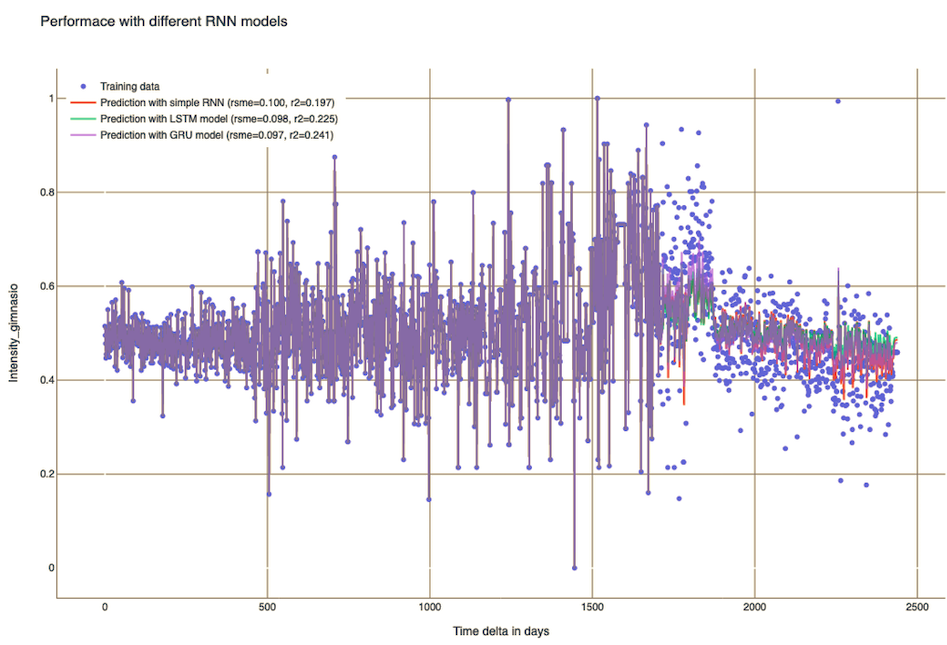

As in the GP, CNP outperforms other non-stochastic processes as Neural Networks in it's capability to manage uncertainty. The model learns the data with its assiciated uncertainty so pass predictions with its associated uncertainty. Neural Netowrks are very flexible in learning data series, being its flexibility its major limitation the accuracy of the learning process. 